<a href="https://colab.research.google.com/github/mattbal/allumer/blob/master/WorkingCancerDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Initial Imports**

In [0]:
#!pip install tensorflow-gpu==2.0.0  #install tensorflow
!pip install -U coremltools==3.0b6 tensorflow==1.13.1 keras==2.2.4
import tensorflow as tf             #imported as tf
tf.__version__ 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
import plotly.io as pio
import cv2

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

Requirement already up-to-date: coremltools==3.0b6 in /usr/local/lib/python3.6/dist-packages (3.0b6)
Requirement already up-to-date: tensorflow==1.13.1 in /usr/local/lib/python3.6/dist-packages (1.13.1)
Requirement already up-to-date: keras==2.2.4 in /usr/local/lib/python3.6/dist-packages (2.2.4)


File Creation/Unzipping

In [0]:
#Authentic Google User
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#Located and get data zip
fid = drive.ListFile({'q':"title='skin-cancer-malignant-vs-benign.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id':fid})
f.GetContentFile('skin-cancer-malignant-vs-benign.zip')
f.keys()
#unzip
!unzip skin-cancer-malignant-vs-benign.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/train/benign/421.jpg  
  inflating: train/malignant/999.jpg  


In [0]:
#set directories
train_dir = 'train'
validation_dir = 'test'
test_pos_dir = 'test/malignant'
test_neg_dir = 'test/benign'
input_dir = 'input'

Build Tensorflow 

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import Model

img_input = layers.Input(shape=(224,224,3))
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
__________

In [0]:
#Compile Model
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [0]:
#Set Generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 224x224
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

NameError: ignored

**Train Model**

In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/15
100/100 - 14s - loss: 3.2246 - acc: 0.5575 - val_loss: 0.5858 - val_acc: 0.6070
Epoch 2/15
100/100 - 9s - loss: 0.6407 - acc: 0.6876 - val_loss: 0.5183 - val_acc: 0.7440
Epoch 3/15
100/100 - 9s - loss: 0.5143 - acc: 0.7465 - val_loss: 0.4509 - val_acc: 0.7880
Epoch 4/15
100/100 - 9s - loss: 0.4586 - acc: 0.7787 - val_loss: 0.3848 - val_acc: 0.8070
Epoch 5/15
100/100 - 9s - loss: 0.4404 - acc: 0.7872 - val_loss: 0.4079 - val_acc: 0.8070
Epoch 6/15
100/100 - 9s - loss: 0.4529 - acc: 0.7930 - val_loss: 0.4414 - val_acc: 0.7380
Epoch 7/15
100/100 - 9s - loss: 0.4083 - acc: 0.8192 - val_loss: 0.3642 - val_acc: 0.8170
Epoch 8/15
100/100 - 9s - loss: 0.4147 - acc: 0.8032 - val_loss: 0.3567 - val_acc: 0.8230
Epoch 9/15
100/100 - 9s - loss: 0.4118 - acc: 0.8373 - val_loss: 0.4546 - val_acc: 0.8080
Epoch 10/15
100/100 - 9s - loss: 0.3238 - acc: 0.8553 - val_loss: 0.4547 - val_acc: 0.7990
Epoch 11/15
100/100 - 9s - loss: 0.3283 - acc: 0.8668 - val_loss: 0.6002 - val_acc: 0.7880
Epoch 1

Text(0.5, 1.0, 'Training and validation loss')

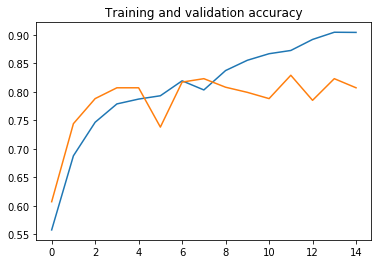

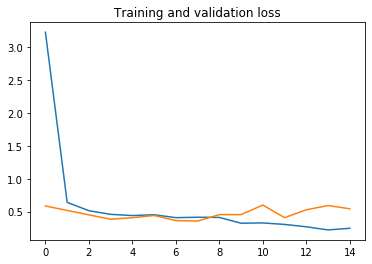

In [0]:
#Graph
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

**PREDICTION**

In [0]:
#predictTest = model.predict_generator(validation_generator,verbose=1)
test_batches = ImageDataGenerator().flow_from_directory(validation_dir,target_size = (224,224),classes = ['benign','malignant'], batch_size=660)
test_imgs, test_labels = next(test_batches)
#plt.plots(test_imgs, titles = test_labels)
test_labels = test_labels[:,0]
print(test_labels)

Found 660 images belonging to 2 classes.
[1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0.
 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0.
 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1.
 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1.
 0. 1. 1. 

In [0]:
predictions = model.predict_generator(test_batches, steps=1)

In [0]:
predictions

array([[0.        ],
       [1.        ],
       [0.        ],
       [0.        ],
       [1.        ],
       [0.        ],
       [0.        ],
       [1.        ],
       [0.        ],
       [1.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [1.        ],
       [0.        ],
       [0.        ],
       [1.        ],
       [0.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.        ],
       [0.        ],
       [1.        ],
       [0.        ],
       [0.        ],
       [1.        ],
       [1.        ],
       [0.        ],
       [1.        ],
       [0.        ],
       [1.        ],
       [1.        ],
       [0.        ],
       [1.        ],
       [1.        ],
       [0.        ],
       [0.99999994],
       [1.        ],
       [0.        ],
       [0.        ],
       [1.        ],
       [1.        ],
       [0.        ],
       [0.        ],
       [0.   

In [0]:
total = 0
correct = 0
wrong = 0
for i in range(len(test_labels)):
  total=total+1
  if(predictions[i] != test_labels[i]):
    correct=correct+1
  else:
    wrong=wrong+1

print("Total " + str(total))
print("Correct " + str(correct))
print("Wrong " + str(wrong))
print("This Neural Network got " + str(correct / total * 100) + "% correct!")

Total 660
Correct 504
Wrong 156
This Neural Network got 76.36363636363637% correct!


In [0]:
total = 0
correct = 0
wrong = 0
for i in range(len(test_labels)):
  if(test_labels[i] == 0):
    total = total + 1
    if(predictions[i] == 0):
      correct = correct + 1
    else:
      wrong = wrong + 1
print("Total " + str(total))
print("Correct " + str(correct))
print("Wrong " + str(wrong))
print("This Neural Network got " + str(correct / total * 100) + "% correct!")

Total 300
Correct 101
Wrong 199
This Neural Network got 33.666666666666664% correct!


In [0]:
model.save("model.h5")

In [0]:
!pip install coremltools
import coremltools

     |████████████████████████████████| 3.4MB 2.8MB/s 


In [0]:
#!pip install -U coremltools==3.0b6 tensorflow==1.13.1 keras==2.2.4
!pip3 show h5py

Name: h5py
Version: 2.8.0
Summary: Read and write HDF5 files from Python
Home-page: http://www.h5py.org
Author: Andrew Collette
Author-email: andrew.collette@gmail.com
License: BSD
Location: /usr/local/lib/python3.6/dist-packages
Requires: six, numpy
Required-by: textgenrnn, tensor2tensor, pymc3, Keras, keras-vis, Keras-Applications


In [0]:
from keras.models import load_model
your_model = tf.keras.models.load_model('model.h5',compile=False)

In [0]:
import coremltools
from tensorflow.keras.applications import ResNet50

model = coremltools.converters.tensorflow.convert(
    './model.h5',
     input_name_shape_dict={'input_1': (1, 224, 224, 3)},
     output_feature_names=['Identity']
)